Install HPI tool and get trainings-data

In [3]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2

# ohne Ausrufezeichen bei Ausführung im lokalen Notebook
!pip install --upgrade deeplearning2020
from deeplearning2020.datasets import ImageWoof

train_data_orig, test_data_orig, classes = ImageWoof.load_data()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Requirement already up-to-date: deeplearning2020 in /usr/local/lib/python3.6/dist-packages (0.4.21)
/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


Init *Tensorflow* and stuff

In [4]:
# TensorFlow ≥2.0 wird benötigt
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
  print("GPU ok")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
%matplotlib inline

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU ok


Ok, take helpers, too

In [0]:
from deeplearning2020 import helpers

#helpers.plot_images(train_data_orig.take(9), classes)

Define the preprocessor

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [300, 300])
    return resized_image, label

In [7]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data_orig)

train_data = train_data_orig.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data_orig.map(preprocess) \
  .batch(batch_size).prefetch(1)

train_data = train_data.shuffle(1000) 

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <ShuffleDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


Show train data

In [0]:
#helpers.plot_images(train_data.unbatch().take(9), classes)

Define the net

In [9]:
# model
learning_rate=0.003
momentum=0.9
dense_neurons=1000
n_filters=256
first_kernel_size=(5,5)

n_classes=len(classes)

activation='elu'

# Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
input_layer = Input(shape=(300, 300, 3))

# Convolutional Neural Network
# 6 Convolutional Layers mit jeweils einer Max Pooling Layer
model = Conv2D(
    filters=64,
    kernel_size=first_kernel_size,
    activation=activation
)(input_layer)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = 64, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(filters = n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(
    dense_neurons,
    activation=activation
)(model)

model = Dense(
    dense_neurons / 2,
    activation='tanh'
)(model)

# Output Layer
output = Dense(n_classes, activation="softmax")(model)

CNN_model = Model(input_layer, output)

# Kompilieren des Modells
## Stochastic Gradient Descent -> langsamer aber genauer
#optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
## Adam -> schneller, für schnellere aber nicht 100% Ergebnisse
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
CNN_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
CNN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 296, 296, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 256)       147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 256)       0     

Training

In [1]:
# Training des Modells
history = CNN_model.fit(
    train_data,
    epochs=2,
    validation_data=test_data
)

NameError: ignored

Tranings-Ergebnis anzeigen

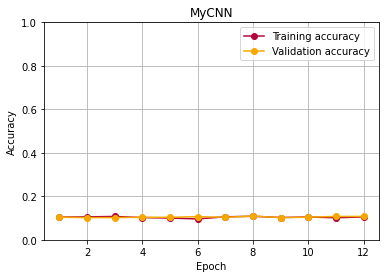

In [11]:
helpers.plot_history('MyCNN', history, 0)

Submission

In [0]:
from deeplearning2020 import Submission
Submission('4d712a6d0ae14f2a395c992ad3627476', '3', CNN_model).submit()

Using TensorFlow backend.


Model wird validiert...


  0% (1 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:06:33